<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_06_pytorch_pipeline_03_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing Script

**Overview:**

In this step, we focus on creating a set of modular functions directly within the notebook. These functions are designed to handle various aspects of data preparation and feature selection for machine learning tasks. The primary goal is to ensure that these functions are reusable, easy to maintain, and adaptable to different datasets and projects.

**Purpose:**

1. **Modularity and Reusability:** By defining these functions in a modular manner, we can reuse them across different notebooks and projects without needing to rewrite code. This helps in maintaining a clean and efficient workflow.
   
2. **Separation of Concerns:** Each function is responsible for a specific task, such as loading data, cleaning column names, handling categorical variables, splitting data, defining preprocessing steps, and calculating class weights. This separation of concerns makes the code easier to understand, debug, and modify.

3. **Flexibility:** Modular functions can be easily adapted to different datasets by changing the input parameters. This makes the codebase more flexible and generalizable for various machine learning tasks.

4. **Maintainability:** If any changes or improvements are needed, they can be made in one place without affecting the rest of the code. This makes the code easier to maintain and update over time.

**Summary:**

By defining these modular functions in the notebook, we aim to create a robust, flexible, and reusable set of tools for data preparation and feature selection. This approach enhances code clarity, reduces redundancy, and facilitates a streamlined workflow for machine learning projects. Once verified, these functions can be moved to a separate script to further improve code organization and reusability.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

def save_data(X_train_processed, X_test_processed, y_train, y_test, filename='preprocessed_data.npz'):
    np.savez(filename, X_train_processed=X_train_processed, X_test_processed=X_test_processed, y_train=y_train, y_test=y_test)
    print("Data preparation complete and saved.")


## ANOVA Feature Selection Script

**Overview:**

The ANOVA Feature Selection Script is designed to evaluate and select the most relevant features from a dataset using the Analysis of Variance (ANOVA) method. The script leverages modular functions for data preprocessing, feature selection, and evaluation, ensuring a clean, reusable, and maintainable workflow. The goal is to identify the optimal number of features that yield the best performance for a machine learning model.

**Purpose:**

1. **Feature Selection:** The script uses ANOVA to rank and select features based on their statistical significance, helping to reduce the dimensionality of the dataset and improve model performance.

2. **Modularity:** By using functions defined in the `ml_utils.py` and `anova_feature_selection.py` scripts, the code remains modular and easy to maintain. Each function performs a specific task, such as data loading, preprocessing, or feature evaluation, allowing for clear separation of concerns.

3. **Evaluation:** The script evaluates different numbers of features (defined by the parameter `k`) to determine the optimal set of features that maximizes the model's F1-score. This iterative approach ensures that the best subset of features is selected for the model.

4. **Timing:** The script includes a timer to measure the total execution time, providing insights into the computational cost of the feature selection process.

**Summary:**

The ANOVA Feature Selection Script is an essential tool for selecting the most relevant features from a dataset. By evaluating different feature subsets and identifying the optimal number of features, the script helps improve the performance of machine learning models. The use of modular functions ensures that the code is reusable, maintainable, and easy to understand, facilitating a streamlined and efficient workflow for feature selection tasks.

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
        return predictions.numpy().squeeze()

def evaluate_anova(X_train, y_train, X_test, y_test, preprocessor, class_weights, k_values):
    f1_scores = []

    for k in k_values:
        logging.info(f"Evaluating ANOVA with {k} features")

        anova_pipeline = SklearnPipeline(steps=[
            ('preprocessor', preprocessor),
            ('anova', SelectKBest(score_func=f_classif, k=k))
        ])

        X_train_anova = anova_pipeline.fit_transform(X_train, y_train)
        X_test_anova = anova_pipeline.transform(X_test)

        undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_anova, y_train)

        X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test_anova, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
        nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

        y_pred = nn_estimator.predict(X_test_tensor.numpy())
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        f1_scores.append(f1)
        logging.info(f"Number of features: {k}, F1-score: {f1}")

    return k_values, f1_scores

def plot_f1_scores(k_values, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, f1_scores, marker='o')
    plt.title('F1-Score vs. Number of Features (ANOVA)')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.xticks(k_values)
    plt.grid()
    plt.show()


## Testing the Main Function

**Overview:**

The primary goal of this phase is to validate the functionality and performance of the main workflow designed for ANOVA feature selection. By testing the main function directly in the notebook, we ensure that all modular functions integrate seamlessly and operate as expected before transitioning them into a reusable script. This approach is crucial for debugging and refining the code to achieve optimal performance.

**Purpose:**

1. **Validation of Workflow:** Testing the main function within the notebook allows us to verify that the entire workflow—from data loading and preprocessing to feature selection and evaluation—functions correctly. This step ensures that all components work together harmoniously.

2. **Performance Measurement:** Including a timer to measure the execution time of the main function provides valuable insights into the computational efficiency of the feature selection process. This helps in identifying and optimizing any bottlenecks.

3. **Debugging and Refinement:** By running the main function in the notebook, we can easily debug any issues and make necessary adjustments. This iterative process ensures that the final code is robust and error-free.

4. **Modularity and Reusability:** The main function leverages modular functions defined in the notebook, promoting a clean and organized code structure. Once validated, these functions can be moved to a separate script, ensuring reusability and maintainability across different projects.

**Summary:**

Testing the main function in the notebook is a critical step to ensure that all aspects of the ANOVA feature selection process work correctly and efficiently. By validating the workflow, measuring performance, and refining the code, we can confidently transition to a modular and reusable script that enhances the overall data analysis and machine learning pipeline. This methodical approach aligns with best practices in data science, ensuring that the final solution is both robust and professional.

This detailed testing phase echoes your preference for starting with a robust foundation, similar to the incremental and thorough learning strategies you've adopted in your projects.

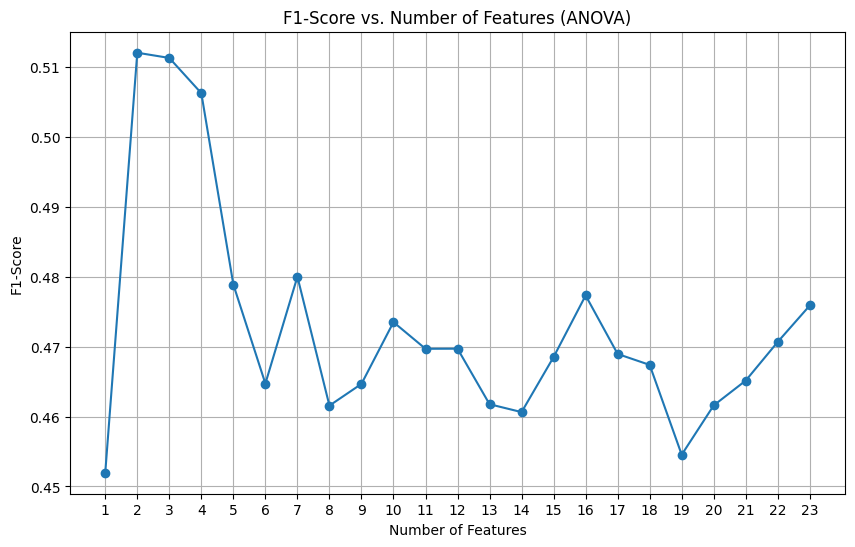

Optimal number of features: 2
Execution time: 426.52 seconds


In [10]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import logging

# Dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

def run_anova_feature_selection(url, categorical_columns, target):
    start_time = time.time()

    set_seed(42)
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    class_weights = calculate_class_weights(y_train)

    # Define range of k values
    k_values = range(1, X_train.shape[1] + 1)

    # Evaluate ANOVA feature selection
    k_values, f1_scores = evaluate_anova(X_train, y_train, X_test, y_test, preprocessor, class_weights, k_values)

    # Plot F1-scores
    plot_f1_scores(k_values, f1_scores)

    # Find the optimal number of features
    optimal_k = k_values[np.argmax(f1_scores)]
    print(f"Optimal number of features: {optimal_k}")

    # Save the optimal number of features
    with open('optimal_anova_features.txt', 'w') as f:
        f.write(str(optimal_k))

    end_time = time.time()
    print(f"Execution time: {end_time - start_time:.2f} seconds")

if __name__ == "__main__":
    run_anova_feature_selection(url, categorical_columns, target)


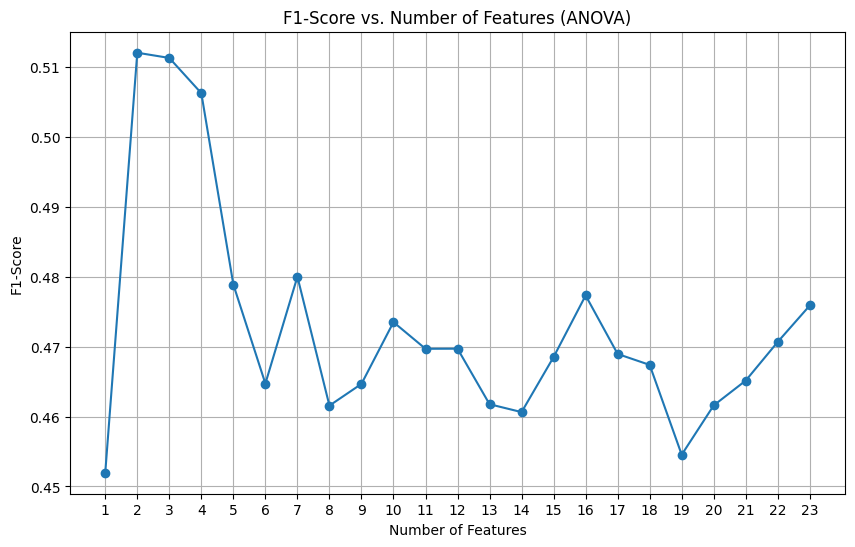

Optimal number of features: 2
Execution time: 483.47 seconds


In [1]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Import the function from the correct script
from run_anova_feature_selection import run_anova_feature_selection

# Run the ANOVA feature selection with the parameters
run_anova_feature_selection(url, categorical_columns, target)

